In this notebook, we will investigate the transformation of the electronic Hamiltonian of a molecule into a Hamiltonian acting on a quantum register, spanned by a collection of qubits. We will then continue to build quantum circuits to simulate the time evolution under the Hamiltonian.

This implementation is very straightforward - if $K$ is the number of molecular spin orbitals $\chi_0, \dots, \chi_{K-1}$, we use K qubits and consider the full Fock space which also has dimension $2^K$. We represent all matrices as full $2^K \times 2^K$ matrices. This is simple, but of course only works for small values of $K$ - for larger values, using sparse matrices or symbolic manipulations like those provided by OpenFermion would be required.

First, we provide a helper function that will construct creation and annihilation operators. A creation operator $a^\dagger_p$ with index $p$ maps the element of the occupation number basis given by the binary string $b$ to either zero (if $b_p = 1$) or to the member which is given by the binary string $b'$, where $b'$ is obtained from b by setting the digit at position p to 1 and leaving all other members unchanged. In addition, there is a prefactor
$$
\sum_{i=0}^{p-1} (-1)^{b_i}
$$
The annihilation operator has the same prefactor, is zero if $b_p = 0$ and otherwise sets the digit at position $p$ to one. To transform between the qubit space and the Fock space, we use the Jordan-Wigner transform. With that transform, a member of the occupation number basis which is described by a binary bit string of length K is mapped to the member of the computational basis that is described by the same binary string.

In [1]:
import numpy as np

In [2]:
#######################################
# Return a creation operator in the   #
# occupation number basis             #
# Use Jordan-Wigner transform         #
#######################################
def creatorJW(p, K):
    result = np.zeros((2**K,2**K))
    # Go through the columns, i.e. the members of the 
    # occupation number basis
    mask = 1 << p
    for b in range(2**K):
        # 
        # The creator will only give a non-zero result
        # if position p is not yet set
        #
        if (0 == (mask & b)):
            bprime = b + mask
            factor = 1
            for i in range(p):
                factor = factor * (-1)**((b >> i) % 2)
            result[bprime][b] = factor
    return result


#######################################
# Return an annihilation operator     #
# Our matrices are real, so we just   #
# take the transpose                  #
#######################################
def annihilatorJW(p, K):
    return creatorJW(p,K).T

As a little test, we can check the commutation relations.

In [3]:
#######################################
# Test commutators                    #
#######################################
def testCommutatorsFermions(K, creator, annihilator):
    for p in range(K):
        # First test that the creator squares to zero
        apdagger = creator(p,K)
        actual = np.matmul(apdagger, apdagger)
        if (np.linalg.norm(actual) > 10**(-12)):
            print("Square not zero for p = ", p)
        # Now test the commutators with all annihilators
        for q in range(K):
            aq = annihilator(q,K)
            actual = np.matmul(apdagger, aq) + np.matmul(aq, apdagger)
            if (p == q):
                expected = np.identity(2**K)
            else:
                expected = np.zeros((2**K, 2**K))
            if (np.linalg.norm(expected - actual) > 10**(-12)):
                print("p = ", p, "q = ", q, " ---> error! Expected:\n ", expected, "got:\n ", actual )

In [4]:
testCommutatorsFermions(4, creatorJW, annihilatorJW)

Similarly, we will need the Pauli X and Z matrices, acting on qubit p. These actions are actually quite simple. $X$ just performs a bit flip i.e. an XOR with the target bit, whereas Z just multiplies by -1 if the bit is set.

In [5]:
#######################################
# Return the Pauli X operator         #
#######################################
def X(p, K):
    result = np.zeros((2**K,2**K))
    # Go through the columns, i.e. the members of the 
    # computational basis
    mask = 1 << p
    for b in range(2**K):
        bprime = b ^ mask
        result[bprime][b] = 1
    return result

#######################################
# Return the Pauli Z operator         #
#######################################
def Z(p, K):
    result = np.zeros((2**K,2**K))
    # Go through the columns, i.e. the members of the 
    # computational basis
    mask = 1 << p
    for b in range(2**K):
        result[b][b] = (-1)**((b >> p) % 2)
    return result


In [6]:
#######################################
# Test commutators                    #
#######################################
def testCommutatorsPauli(K):
    for p in range(K):
        # First test that the X and Z operators both square to one
        Xp = X(p,K)
        actual = np.matmul(Xp, Xp)
        if (np.linalg.norm(actual-np.identity(2**K)) > 10**(-12)):
            print("Square not one for X_p, p = ", p)
        Zp = Z(p,K)
        actual = np.matmul(Zp, Zp)
        if (np.linalg.norm(actual - np.identity(2**K)) > 10**(-12)):
            print("Square not one for Z_p, p = ", p)
        # Now test commutators. X and Y should commute on different qubits and anti-commute
        # on the same qubit. We start with the relations for the same qubit
        if (np.linalg.norm(np.matmul(Xp, Zp) + np.matmul(Zp, Xp)) > 10**(-12)):
                    print(" Xp and Zp do not anti-commute for p =", p)
        # Now do different qubits
        for q in range(K):
            Xq = X(q,K)
            Zq = Z(q,K)
            # For different qubits, all operators should commute
            if p != q:
                if (np.linalg.norm(np.matmul(Xp, Xq) - np.matmul(Xq, Xp)) > 10**(-12)):
                    print(" Xp and Xq do not commute for p =", p, " and q = ", q)
                if (np.linalg.norm(np.matmul(Zp, Zq) - np.matmul(Zq, Zp)) > 10**(-12)):
                    print(" Zp and Zq do not commute for p =", p, " and q = ", q)
                if (np.linalg.norm(np.matmul(Xp, Zq) - np.matmul(Zq, Xp)) > 10**(-12)):
                    print(" Xp and Zq do not commute for p =", p, " and q = ", q)
                if (np.linalg.norm(np.matmul(Zp, Xq) - np.matmul(Xq, Zp)) > 10**(-12)):
                    print(" Zp and Xq do not commute for p =", p, " and q = ", q)


In [7]:
testCommutatorsPauli(4)

The next task will be to write a given matrix as a linear combination of products of Pauli operators. In fact, we can write each matrix as
$$
\sum_{\alpha, \beta} a_{\alpha, \beta} X^\alpha Z^\beta
$$
where $\alpha$ and $\beta$ are K-bit strings, and $X^\alpha$ has the obvious meaning 
$$
X^\alpha = (X^{(K-1)})^{\alpha_{K-1}} \cdots 
$$
To find the coefficients in this expansion, we can utilize the fact that a product of Pauli-matrices is trace-free. To find the coefficient at $\alpha, \beta$, we can therefore multiply the matrix by $Z^\beta X^\alpha$ from the left, take the trace and divide by $2^K$.

In [8]:
################################################
# Return the decomposition of a matrix into    #
# a sum of products of Pauli matrices          #
# We return the result as a matrix with coeff. #
# alpha, beta where the matrix element at      #
# [alpha, beta] is the coefficient of          #
# X**alpha Z**beta                             #
################################################
def pauliDecomposition(A):
    N = np.shape(A)[0]
    if (np.shape(A)[1] != N):
        raise("A is not a square matrix")
    K = int(np.log2(N))
    if (2**K != N):
        raise("Dimension not a power of two")
    result = np.zeros((2**K, 2**K))
    for alpha in range(2**K):
        # First calculate Xalpha
        Xalpha = np.identity(2**K)
        for i in range(K):
            if ((alpha >> i) % 2):
                Xalpha = np.matmul(Xalpha, X(i, K))
        # Now iterate overall over all betas
        for beta in range(2**K):
            # Calculate Zbeta
            Zbeta = np.identity(2**K)
            for i in range(K):
                if ((beta >> i) % 2):
                    Zbeta = np.matmul(Zbeta, Z(i, K))
            # Now multiply our matrix from the left 
            check = np.matmul(Zbeta, np.matmul(Xalpha, A))
            result[alpha][beta] = np.trace(check) / 2**K
    return result


#################################################
# Helper method to print out a decomposition    #
#################################################
def printPauliDecomposition(D):
    N = np.shape(D)[0]
    if (np.shape(D)[1] != N):
        raise("A is not a square matrix")
    K = int(np.log2(N))
    if (2**K != N):
        raise("Dimension not a power of two")
    for alpha in range(N):
        for beta in range(N):
            coeff = D[alpha, beta]
            if coeff != 0:
                string = ""
                # First print Xalpha
                for i in range(K):
                    if ((alpha >> i) % 2):
                        string+=("X{0}".format(i))
                # Now print Zbeta
                for i in range(K):
                    if ((beta >> i) % 2):
                        string+=("Z{0}".format(i))
                if ((alpha == 0) and (beta == 0)):
                    string = "E"
                print("{0:.3f}*".format(coeff)+string)
                
#############################################
# Given a Pauli decomposition, turn this    #
# into a full matrix                        #
#############################################
def pauliDecompositionToMatrix(D):
    N = np.shape(D)[0]
    if (np.shape(D)[1] != N):
        raise("Not a square matrix")
    K = int(np.log2(N))
    if (2**K != N):
        raise("Dimension not a power of 2")
    result = np.zeros((N,N))
    # Go through the matrix, i.e. each combination of alpha and beta
    for alpha in range(N):
        for beta in range(N):
            haveTemp = 0
            temp = np.identity(N)
            coeff = D[alpha][beta]
            if (coeff != 0):
                # first calculate X**alpha
                for i in range(K):
                    if (1 == ((alpha >> i) % 2)):
                        if (0 == haveTemp):
                            temp = X(i,K)
                            haveTemp = 1
                        else:
                            temp = np.matmul(temp,X(i,K))
                # now do the same for Z**beta
                for i in range(K):
                    if (1 == ((beta >> i) % 2)):
                        if (0 == haveTemp):
                            temp = Z(i,K)
                            haveTemp = 1
                        else:
                            temp = np.matmul(temp,Z(i,K))
                result = result + coeff*temp
    return result

In [9]:
A = np.matmul(Z(0,2), X(1,2)) + 0.3*np.matmul(Z(1,2), Z(0,2)) + 5*np.identity(4)
D = pauliDecomposition(A)
printPauliDecomposition(D)

5.000*E
0.300*Z0Z1
1.000*X1Z0


We can now check that the Jordan-Wigner transform is correct. Recall that
$$
X_+ = \frac{1}{2} (X - IY) = \frac{1}{2} (X + XZ)
$$
Let us verify this.

In [10]:
0.5*(np.matmul(X(0,1),Z(0,1)) + X(0,1))

array([[0., 0.],
       [1., 0.]])

Now the Jordan-Wigner transform maps $a_p^\dagger$ to
$$
X_+^{(p)} Z^{(p-1)} \cdots Z^{(0)}
$$
which then becomes
$$
\frac{1}{2} X^{(p)} Z^{(p-1)} \cdots Z^{(0)} + \frac{1}{2} X^{(p)} Z^{(p)} Z^{(p-1)} \cdots Z^{(0)}
$$
or, after reording the Z-factors
$$
\frac{1}{2} X^{(p)} Z^{(0)}\cdots Z^{(p-1)}  + \frac{1}{2} X^{(p)} Z^{(0)} \cdots Z^{(p-1)} Z^{(p)}  
$$

In [11]:
printPauliDecomposition(pauliDecomposition(creatorJW(3,4)))

0.500*X3Z0Z1Z2
0.500*X3Z0Z1Z2Z3


Next, let us take a look at the Bravyi-Kitaev (BK) transform. With that transformation, a member
$$
|f_{K-1}, \dots, f_0 \rangle
$$
of the occupation number basis is mapped to the member of the binary basis described by the bit string $BK(f)$. The encoding BK can - in case K is a power of 2 - be described recursively. Given a bit string $f$ of length $2K$, we first apply the transform to the first and the last $K$ bits. Then we add the highest bit of the result for the first part to that for the second part and concatenate the resulting strings again. 

In [12]:
###########################################
# Given a binary vector f, return the     #
# binary string BK(f)                     #
###########################################
def BK(f, K):
    #
    # First verify that K is a power of 2
    #
    if (2**int(np.log2(K)) != K):
        raise("Dimension not a power of two")
    # Cut off everything above position K
    f = f ^ ((f >> K) << K)
    # We are done if K is one
    if (K == 1):
        return f
    N = K // 2
    # Call the BK transform on the first and second part
    # recursively
    partI = BK(f, N)
    partII = BK((f >> N), N)
    # put full parity into MSB of part II
    MSBpartI = (partI >> (N-1)) << (N-1)
    partII = MSBpartI ^ partII
    return partI ^ (partII << N)

The way this is usually presented is in terms of a matrix $\beta$, such that the bit string $b = BK(f)$ is related to the bit string $f$ by
$$
b_i = \sum_{k} \beta_{ik} f_k
$$
Let us form and print this matrix to compare the results of our function with the literature.

In [13]:
#############################################
# Create the BK transformation matrix       #
#############################################
def betaBK(K):
    #
    # The rows the matrix are the results of the
    # transformations of the "unit vectors" with only
    # one position different from zero
    # 
    result = np.zeros((K,K))
    for i in range(K):
        e = 1 << i
        column = BK(e, K)
        # Now form the row in the matrix
        # by extracting the bits from column
        for j in range(K):
            result[j][i]= (column >> j) % 2
    return result

In [14]:
betaBK(4)

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 1., 1., 1.]])

We can now again build creation and annihilation operators based on that transform. To calculate the action of, say, $a_p^\dagger$, we have to first apply the inverse of the BK transform to get from qubit space into the Fock space. Then we apply the creation in Fock space, which will give us a different member of the occupation number basis plus a phase factor $\pm 1$. We then transform the basis vector back using the BK transform and apply the phase again. So we first need to find the inverse of the BK transform on the level of bit strings.

In [15]:
###########################################
# Given a binary vector f, return the     #
# binary string BKinv                     #
###########################################
def BKinv(f, K):
    #
    # First verify that K is a power of 2
    #
    if (2**int(np.log2(K)) != K):
        raise("Dimension not a power of two")
    # Cut off everything above position K
    f = f ^ ((f >> K) << K)
    # We are done if K is one
    if (K == 1):
        return f
    N = K // 2
    # Split our string in two parts
    partII = (f >> N)
    partI = f ^ (partII << N)
    # Before calling the routine recursively, we have to modify
    # its highest bit to only contain the parity of the
    # highest part. We do this by adding the highest
    # bit of the first part
    msb = (partI >> (N-1)) << (N-1)
    partII = partII ^ msb
    return BKinv(partI, N ) + ((BKinv(partII, N)) << N)

In [16]:
# 
# Let us test this 
#
for i in range(2**8):
    bk = BK(i,8)
    assert(i == BKinv(bk, 8))

In [17]:
############################################
# Return a matrix that - with respect to   #
# the computational basis - describes the  #
# creation operator                        #
############################################
def creatorBK(p,K):
    result = np.zeros((2**K, 2**K))
    mask = 1 << p
    #
    # Go through all members of the computational
    # basis, i.e. all columns of our matrix
    #
    for b in range(2**K):
        f = BKinv(b, K)
        # 
        # The creator will only give a non-zero result
        # if position p is not yet set
        #
        if (0 == (mask & f)):
            fprime = f + mask
            factor = 1
            for i in range(p):
                factor = factor * (-1)**((f >> i) % 2)
            bprime = BK(fprime, K)
            result[bprime][b] = factor
    return result

def annihilatorBK(p, K):
    return creatorBK(p,K).T

In [18]:
creatorBK(1,2)

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [19]:
testCommutatorsFermions(8, creatorBK, annihilatorBK)

Now let us try to transform the Hamiltonian. Our strategy is to first express the Hamiltonian in the second quantization as a linear combination of products of creation and annihilation operator. Then we use the above procedure to write this as a sum of products of Pauli operators.

So our starting point is the decomposition
$$
H = \sum_{p,q} \langle \chi_p | h | \chi_q \rangle + \frac{1}{2} \sum_{p,q,r,s}  \langle pq | V | sr \rangle a^\dagger p a^\dagger q a_s a_r
$$
We will use Psi4 to obtain the integrals in the AO basis that we then transform to the MO basis. We also need a convention to map spin orbitals to spatial integrals. We will use the convention that the first half of the spin orbitals are spin up, the second half is spin down. Specifically,
$$
\chi_0 = \psi_+ \alpha
$$
$$
\chi_1 = \psi_- \alpha
$$
$$
\chi_2 = \psi_+ \beta
$$
$$
\chi_3 = \psi_- \beta
$$
Let us first obtain the integrals. Note that Psi4 stores the integrals with a different order of the indices, namely according to the chemists convention
$$
\langle p q | V | r s \rangle = [p r | q s]
$$

In [20]:
import psi4
# Use symmetry c1, otherweise Psi4 will return the coefficient matrix per irrep
h2_template = """
H 0 0 -**R/2**
H 0 0 **R/2**

units bohr
symmetry c1
"""
R = 1.4
h2 = psi4.geometry(h2_template.replace('**R/2**', str(0.5*R)))
h2.update_geometry()
psi4.set_options({'basis': 'sto-3g'})
# First we initialize the wave function object 
wfn = psi4.core.Wavefunction.build(h2, psi4.core.get_global_option('basis'))
# Once we have the wave function, we can now initialize the
# mints helper class that can calculate our integrals. 
mints = psi4.core.MintsHelper(wfn.basisset())
I = np.asarray(mints.ao_eri())
Hcore = np.asarray(mints.ao_kinetic()) + np.asarray(mints.ao_potential())
#
# Do a Hartree-Fock RHF calculation and get coefficient matrix
#
e, wfn = psi4.energy('SCF', return_wfn=True)
C = wfn.Ca().to_array()
#
# Transform matrices to MO basis
#
H_mo = np.einsum('ui,vj,uv', C, C, Hcore)
I_mo = np.einsum('ui, vj, sk, tl, uvst', C, C, C, C, I)

In [21]:
################################
# Return the spin of chi_p     #
################################
def getSpin(p, K):
    if (p < (K // 2)):
        return 1
    return -1
    #return p % 2

################################
# Return the spatial part of   #
# chi_p                        #
################################
def getSpatial(p, K):
    return p % (K//2)
    # return p // 2

In [22]:
###############################################
# Assemble the Hamiltonian.                   #
###############################################
def hamiltonian(K, H_mo, I_mo, creator, annihilator, decimals=12):
    N = K // 2
    if (2*N != K):
        raise("K must be even")
    H = np.zeros((2**K, 2**K))
    #
    # First do the core hamiltonian part. Note that 
    # we only get a contribution if p and q have the same
    # spin
    #
    for p in range(K):
        for q in range(K):
            if (getSpin(p, K) == getSpin(q, K)):
                H = H + H_mo[getSpatial(p, K)][getSpatial(q,K)] * np.matmul(creator(p,K), annihilator(q,K))
    #
    # Now we apply a similar logic to the interaction part
    #
    for p in range(K):
        for q in range(K):
            for r in range(K):
                for s in range(K):
                    if (getSpin(p,K) == getSpin(r, K)) and (getSpin(q,K) == getSpin(s, K)):
                        coeff = 0.5*I_mo[getSpatial(p, K)][getSpatial(r, K)][getSpatial(q, K)][getSpatial(s,K)]
                        matrix  =np.matmul(creator(p,K),np.matmul(creator(q,K), np.matmul(annihilator(s, K), annihilator(r,K))))
                        H = H +  coeff*matrix
    return np.around(H, decimals)

In [23]:
#################################################
# A little helper to print a matrix             #
#################################################
def printMatrix(A):
    K = np.shape(A)[0]
    for p in range(K):
        s = ""
        for q in range(K):
            if (A[p][q] != 0):
                s = s + "{0:6.2f}".format(A[p][q])
            else:
                s = s + "  00  "
        print(s)        

In [24]:
H = hamiltonian(4, H_mo, I_mo, creatorBK, annihilatorBK, 2)
printMatrix(H)

  00    00    00    00    00    00    00    00    00    00    00    00    00    00    00    00  
  00   -1.25  00    00    00    00    00    00    00    00    00    00    00    00    00    00  
  00    00   -0.25  00    00    00    00    0.18  00    00    00    00    00    00    00    00  
  00    00    00   -1.06  00    00    0.18  00    00    00    00    00    00    00    00    00  
  00    00    00    00   -1.25  00    00    00    00    00    00    00    00    00    00    00  
  00    00    00    00    00    0.21  00    00    00    00    00    00    00    00    00    00  
  00    00    00    0.18  00    00   -1.06  00    00    00    00    00    00    00    00    00  
  00    00    0.18  00    00    00    00   -1.83  00    00    00    00    00    00    00    00  
  00    00    00    00    00    00    00    00   -0.48  00    00    00    00    00    00    00  
  00    00    00    00    00    00    00    00    00   -0.36  00    00    00    00    00    00  
  00    00    00    00    00  

In [25]:
epsilon, _ = np.linalg.eigh(H)

In [26]:
epsilon

array([-1.85024688, -1.25      , -1.25      , -1.25      , -1.25      ,
       -1.24      , -1.16      , -1.16      , -0.88      , -0.48      ,
       -0.48      , -0.36      , -0.36      , -0.22975312,  0.        ,
        0.21      ])

In [27]:
D = pauliDecomposition(H)
printPauliDecomposition(D)

-0.812*E
0.171*Z0
0.119*Z1
-0.223*Z0Z1
0.171*Z2
0.168*Z0Z2
-0.001*Z1Z2
0.167*Z0Z1Z2
0.001*Z3
0.001*Z0Z3
0.119*Z1Z3
-0.001*Z0Z1Z3
0.001*Z2Z3
0.176*Z0Z2Z3
-0.223*Z1Z2Z3
0.167*Z0Z1Z2Z3
0.045*X0X2
-0.045*X0X2Z1
0.045*X0X2Z3
-0.045*X0X2Z1Z3


In [28]:
check = pauliDecompositionToMatrix(D)
assert(np.linalg.norm(check - H ) < 10**(-12))

Now let us try whether we can further simplify this. So far, we have been acting on the full 16-dimensional Fock space. However, we know that the Hamiltonian commutes with the number operator, and we are only interested in the subspace spanned by two-electron states. So we can set the Hamiltonian to zero outside this space. In other words, instead of the full Hamiltonian, we look at the matrix $HP$ where $P$ is the projection onto the 2-electron subspace. So let us calculate this matrix.  

In [29]:
#################################################
# Calculate the projection onto the N-electron  #
# subspace                                      #
# Note that we need a different matrix for a    #
# BK transformed basis                          #
#################################################
def projection(K,N, BK=1):
    result = np.zeros((2**K, 2**K))
    for b in range(2**K):
        #
        # Calculate weight of b, i.e. number of bits set
        #
        if (0 == BK):
            particles = bin(b).count("1")
        else:
            particles = bin(BKinv(b, K)).count("1")
        if (particles == N):
            result[b][b] = 1
    return result

In [30]:
printMatrix(projection(4,2))

  00    00    00    00    00    00    00    00    00    00    00    00    00    00    00    00  
  00    1.00  00    00    00    00    00    00    00    00    00    00    00    00    00    00  
  00    00    1.00  00    00    00    00    00    00    00    00    00    00    00    00    00  
  00    00    00    1.00  00    00    00    00    00    00    00    00    00    00    00    00  
  00    00    00    00    1.00  00    00    00    00    00    00    00    00    00    00    00  
  00    00    00    00    00    00    00    00    00    00    00    00    00    00    00    00  
  00    00    00    00    00    00    1.00  00    00    00    00    00    00    00    00    00  
  00    00    00    00    00    00    00    1.00  00    00    00    00    00    00    00    00  
  00    00    00    00    00    00    00    00    00    00    00    00    00    00    00    00  
  00    00    00    00    00    00    00    00    00    00    00    00    00    00    00    00  
  00    00    00    00    00  

In [31]:
H1 = np.matmul(H,projection(4,2))
H1 = H1[:8, :8]

In [32]:
np.shape(H1)

(8, 8)

In [33]:
printMatrix(H1)

  00    00    00    00    00    00    00    00  
  00   -1.25  00    00    00    00    00    00  
  00    00   -0.25  00    00    00    00    0.18
  00    00    00   -1.06  00    00    0.18  00  
  00    00    00    00   -1.25  00    00    00  
  00    00    00    00    00    00    00    00  
  00    00    00    0.18  00    00   -1.06  00  
  00    00    0.18  00    00    00    00   -1.83


In [34]:
D1 = pauliDecomposition(H1)
printPauliDecomposition(D1)

-0.838*E
0.198*Z0
0.213*Z1
-0.198*Z0Z1
0.198*Z2
0.318*Z0Z2
-0.198*Z1Z2
0.307*Z0Z1Z2
0.090*X0X2
-0.090*X0X2Z1


In [35]:
check = pauliDecompositionToMatrix(D1)
#printMatrix(check)
assert(np.linalg.norm(check - H1) < 10**(-12))

Thus we have ten terms in total, acting on three qubits. However, this can be simplified further taking spin into account. The Hamiltonian also commutes with the total spin Z operator. This will split our $8 \times 8$ matrix into two block matrices, in other words, we will reduce the problem to a four-dimensional matrix for which two qubits are sufficient if we further project onto the subspace of total spin zero.

To verify our calculation, let us quickly see which vector (in the computational basis) span the spin-zero subspace. First, there is the Hartree-Fock ground state. In the occupation number basis, this is $|\chi_0 \chi_2 \rangle = |0101\rangle = |5 \rangle$. This is mapped to the element $|7\rangle$ of the computational basis. Then, there is a second state of g symmetry - this is 
$$
|\psi_-^\alpha \psi_-^\beta \rangle = |\chi_1 \chi_3 \rangle = |1010\rangle = |10 \rangle
$$
which is mapped to $|2 \rangle$ under the BK transform. Then, there are two states of u-symmetry:
$$
|\psi_+^\alpha \psi_-^\beta \rangle = |\chi_0 \chi_3 \rangle = |1001\rangle = |9 \rangle
$$
and
$$
|\psi_-^\alpha \psi_+^\beta \rangle = |\chi_1 \chi_2 \rangle = |0110\rangle = |6 \rangle
$$
which are mapped by the BK transform to $|3 \rangle$ and $|6 \rangle$. So we expect that the subspace we are interested in is spanned by
$$
 |2 \rangle, |3\rangle, |6 \rangle, |7 \rangle
$$

In [36]:
#################################################
# Determine the spin of a member of the         #
# computational basis                           #
#################################################
def getSpinForBasis(b, K, BK=1):
    if (0 == BK):
        f = b
    else:
        f = BKinv(b, K)
    spin = 0
    for i in range(K):
        spin = spin + getSpin(i,K) * ((f >> i) % 2)
    return spin



#################################################
# Calculate the projection onto the spin S      #
# subspace                                      #
# Note that we need a different matrix for a    #
# BK transformed basis                          #
#################################################
def spinProjection(K,S, BK=1):
    result = np.zeros((2**K, 2**K))
    for b in range(2**K):
        #
        # Calculate spin of b. To avoid hardcoding
        # any assumptions here, we walk over
        # the bits and sum up their individual spins
        #
        spin = getSpinForBasis(b,K, BK)
        if (spin == S):
            result[b][b] = 1
    return result

In [37]:
H2 = np.matmul(H,np.matmul(spinProjection(4,0), projection(4,2)))
H2 = H2[:8, :8]

In [38]:
H2

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.18],
       [ 0.  ,  0.  ,  0.  , -1.06,  0.  ,  0.  ,  0.18,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.18,  0.  ,  0.  , -1.06,  0.  ],
       [ 0.  ,  0.  ,  0.18,  0.  ,  0.  ,  0.  ,  0.  , -1.83]])

To utilize this to reduce the number of terms in the Pauli decomposition, we can describe the subspace spanned by the four basis vector $|2\rangle, |3\rangle, |6\rangle$ and $|7\rangle$ on which H acts non-trivially as the subspace which is the -1-eigenspace of $Z_1$. Thus, we can obtain a simplified Pauli decomposition by setting all instances of $Z_1$ to minus 1. Alternatively, we can simply select the four columns 2,3,6,7 only and apply a Pauli Decomposition to the result

In [39]:
H2 = H2[:, [2,3,6,7]]
H2 = H2[[2,3,6,7],:]
H2

array([[-0.25,  0.  ,  0.  ,  0.18],
       [ 0.  , -1.06,  0.18,  0.  ],
       [ 0.  ,  0.18, -1.06,  0.  ],
       [ 0.18,  0.  ,  0.  , -1.83]])

In [40]:
D2 = pauliDecomposition(H2)
printPauliDecomposition(D2)

-1.050*E
0.395*Z0
0.395*Z1
0.010*Z0Z1
0.180*X0X1


In [41]:
# Again check that we are still on track.
check = pauliDecompositionToMatrix(D2)
assert(np.linalg.norm((check - H2)) < 10**(-12))

In [42]:
epsilon, _ = np.linalg.eigh(H2)
epsilon

array([-1.85024688, -1.24      , -0.88      , -0.22975312])

Let us now try to implement quantum circuit that realizes $\exp(-itH)$, starting with the last and most simplified Pauli decomposition which we have just obtained (meaning that the unitary operator that we get will **only** be correct on the corresponding four-dimensional subspace). The operator we have to realize is a sum of product of Pauli operators $P_i$. We will use Trotterization, i.e. we will approximate
$$
\exp (-it\sum_i P_i) \approx (-i \frac{t}{n} \prod_i \exp(P_i))^n
$$
So the first thing we need is a way to realize an operator of the form
$$
e^{-itX^\alpha Z^\beta}
$$
It is well known how to do this, see for instance chapter 4 of Nielsen / Chuang. Let us first consider the case that $\alpha = 0$, i.e. we have the exponential of a product of Z-operators. To realize this, we add an ancilla which we call the partity qubit. We then use CNOT gates with the other involved qubits to calculate the parity in this qubit, apply $e^{itZ}$ on this qubit, and uncompute again.

Note that in general, the resulting circuit will not exactly simulate the time evolution operator, but only up to a global phase. We need to keep track of that phase to remove it again once our calculations are complete.

In [43]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import circuit_drawer as drawer
my_style = {'cregbundle': True}

/home/chr/Local/anaconda3/envs/p4env/lib//python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [44]:
###########################################
# Realize the exponential exp(-itZ**beta) #
# The circuit will be added to an existing#
# quantum circuit                         #
# Returns a global phase a such that      #
# circuit = a * exp(-itZ**beta)           #
###########################################
def pureZExponential(beta, circuit, q, t):
    a = 1
    # Trivial case beta = 0:
    if (0 == beta):
        return a
    # Find parity qubit
    l = bin(beta).count("1") + bin(beta).count("0")
    for i in range(l):
        if (1 == ((beta >> i) % 2)):
            parityQbit = i
            break
    # Connect each qubit which is set in beta
    # to the parity qubit with a CNOT gate
    for i in range(l):
        if (1 == ((beta >> i) % 2)) and (i != parityQbit):
            circuit.cx(q[i], q[parityQbit])
    # Next there is an exponential on the Z-axis. This is just the rotation around
    # the Z-axis. However, there is a problem - in Qiskit, the operator RZ(2t) is
    # not really exp(-itZ), but is exp(it) exp(-itZ). This introduces a global phase
    # which we need to track
    circuit.rz(2*t,q[parityQbit])
    a = a * np.exp(1j*t)
    # and finally we uncompute the CNOT gates - make sure to do this in reverse order!
    for i in reversed(range(l)):
        if (1 == ((beta >> i) % 2)) and (i != parityQbit):
            circuit.cx(q[i], q[parityQbit])
    return a

In [45]:
q = QuantumRegister(4,"q")
c = ClassicalRegister(4,"c")
circuit = QuantumCircuit(q, c)

In [46]:
pureZExponential(7, circuit, q, 1.0)

(0.5403023058681398+0.8414709848078965j)

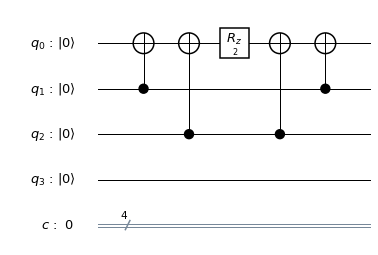

In [47]:
drawer(circuit, style=my_style, output="mpl")

Let us test this for a simple example. We first assemble $Z_0 Z1$ as a matrix, then decompose this as a Pauli operator string and use the above function to create the corresponding quantum circuit. We then apply the unitary simulator coming with qiskit to turn this into a unitary matrix, which we compare to the exponential calculated with numpy.

In [48]:
import scipy.linalg
K = 2
A = np.matmul(Z(0,K), Z(1,K))
#A = Z(0,K)
P = pauliDecomposition(A)
printPauliDecomposition(P)
q = QuantumRegister(2,"q")
c = ClassicalRegister(2,"c")
circuit = QuantumCircuit(q, c)
a = pureZExponential(3, circuit, q, 1.0)
Uexpected = scipy.linalg.expm(-1j*A)*a

1.000*Z0Z1


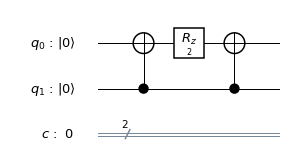

In [49]:
drawer(circuit, style=my_style, output="mpl")

In [50]:
from qiskit import Aer
from qiskit import execute
# Suppress warnings from Marshmallow
import warnings
from marshmallow.warnings import ChangedInMarshmallow3Warning
warnings.simplefilter('ignore', category=ChangedInMarshmallow3Warning)
# Run circuit
backend = Aer.get_backend('unitary_simulator') 
job = execute(circuit, backend)
actual = job.result().get_unitary()

In [51]:
assert(np.linalg.norm(actual - Uexpected) < 10**(-10))

Now let us turn to the case that we have factors of X in the product. Say, for instance, we are looking at $X_0 Z_1$. Then we can use the Hadamard-gate and the fact that
$$
HZH = X
$$
to reduce this to the case that we already know how to do:
$$
e^{-itX} = H e^{-itZ} H
$$
A similar trick works for the case that we have both, X and Z, acting. We can use the phase gate
$$
S = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix}
$$
and
$$
S^\dagger Y S = X  
$$
However, in our case, we do not even need this, as such a term cannot appear in our case as all matrix coefficients are real.

In [52]:
###########################################
# Build a circuit for the exponential     #
# exp(-it X**alpha Z**beta)               #
###########################################
def exponentialCircuit(alpha, beta, circuit, q, t):
    # Trivial case alpha = beta = 0:
    if (0 == beta) and (0 == alpha):
        return np.exp(1j*t)
    a = 1
    # If there is a position where we have an X gate
    # acting on a qubit, add a Hadamard
    # Note that this does in general NOT WORK
    # unless we can assume that no qubit appears on
    # which both, X and Z, act
    l = bin(beta).count("1") + bin(beta).count("0")
    for i in range(l):
        if (1 == ((alpha >> i) % 2)):
            circuit.h(q[i])
            if (1 == ((beta >> i) % 2)):
                raise("Not prepared for XZ terms!")
    # Do exp(-itZ) 
    gamma = alpha | beta
    a = a * pureZExponential(gamma, circuit, q, t)
    # and undo the Hadamards again
    for i in range(l):
        if (1 == ((alpha >> i) % 2)):
            circuit.h(q[i])
    return a

In [53]:
K = 2
A = np.matmul(X(0,K), Z(1,K))
P = pauliDecomposition(A)
printPauliDecomposition(P)
q = QuantumRegister(2,"q")
c = ClassicalRegister(2,"c")
circuit = QuantumCircuit(q, c)
a = exponentialCircuit(1, 2, circuit, q, 1.0)
Uexpected = scipy.linalg.expm(-1j*A)*a

1.000*X0Z1


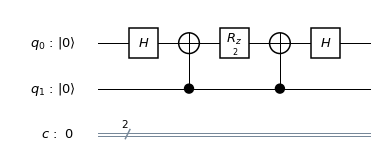

In [54]:
drawer(circuit, style=my_style, output="mpl")

In [55]:
from qiskit import Aer
from qiskit import execute
backend = Aer.get_backend('unitary_simulator') 
job = execute(circuit, backend)
print(job.result().get_unitary())
actual = job.result().get_unitary()

[[ 0.29192658+0.45464871j  0.70807342-0.45464871j  0.        +0.j
   0.        +0.j        ]
 [ 0.70807342-0.45464871j  0.29192658+0.45464871j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.29192658+0.45464871j
  -0.70807342+0.45464871j]
 [ 0.        +0.j          0.        +0.j         -0.70807342+0.45464871j
   0.29192658+0.45464871j]]


In [56]:
assert(np.linalg.norm(actual - Uexpected) < 10**(-10))

Let us now build the circuit for our Hamiltonian, i.e. the composition that we have stored in D2. To do this, we first pick a value for the exponent n in the Trotter approximation, a number which is sometimes called the **Trotter number**. The larger this number, the better the approximation, but the more terms we will have. We then add the same circuit n times in a loop. Each circuit is again a sequence of subcircuits, one for every component in the Pauli decomposition. In addition, we have to keep track of the global phase.

In [57]:
#################################################
# Build a circuit that - using Trotterization   #
# approximates exp(-iHt), where H is given by   #
# a Pauli decomposition D.                      #
# Returns a global phase a such that the        #
# circuit realizes a * exp(-iHt)                #
#################################################
def trotterApproximation(D, circuit, q,t, n):
    N = np.shape(D)[0]
    K = int(np.log2(N))
    a = 1
    dt = t / n
    #
    # We first need a loop over the powers
    # 
    for i in range(n):
        #
        # Now we need an inner loop over the terms in the
        # Pauli decomposition
        #
        for alpha in range(N):
            for beta in range(N):
                coeff = D[alpha][beta]
                if (coeff != 0):
                    #
                    # add circuit for this term
                    #
                    a = a * exponentialCircuit(alpha, beta, circuit, q, coeff * dt)
    return a

In [58]:
#
# Let us do a first test with a rather simple matrix and a very large
# Trotter number
#
K = 2
t = 0.2
A = np.matmul(X(0,K), Z(1,K)) + 50*np.identity(4) + X(1,K)
P = pauliDecomposition(A)
printPauliDecomposition(P)
q = QuantumRegister(2,"q")
c = ClassicalRegister(2,"c")
circuit = QuantumCircuit(q, c)
a = trotterApproximation(P, circuit, q, t, 100)
Uexpected = scipy.linalg.expm(-1j*t*A)*a
backend = Aer.get_backend('unitary_simulator') 
job = execute(circuit, backend)
actual = job.result().get_unitary()
print("Deviation: ", np.linalg.norm(actual - Uexpected))

50.000*E
1.000*X0Z1
1.000*X1
Deviation:  0.0007893762737753867


Now we are finally ready to apply this to our Hamiltonian. We start with the Trotter number n = 2. Recall that our Hamiltonian was H2, with Pauli decomposition stored in D2.

In [59]:
q = QuantumRegister(2,"q")
c = ClassicalRegister(2,"c")
circuit = QuantumCircuit(q, c)
a = trotterApproximation(D2, circuit, q, t, 2)
Uexpected = scipy.linalg.expm(-1j*t*H2)*a
backend = Aer.get_backend('unitary_simulator') 
job = execute(circuit, backend)
actual = job.result().get_unitary()
print("Relative deviation: ", np.linalg.norm(actual - Uexpected) / np.linalg.norm(Uexpected)) 

Relative deviation:  0.0020029528745024792


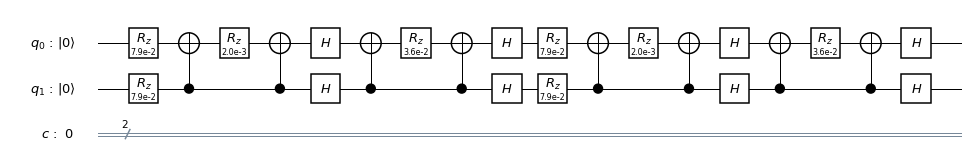

In [60]:
drawer(circuit, style=my_style, output="mpl")

In [61]:
circuit.size()

24

This is already nice, but to reach what is usually called chemical accuracy, i.e. an error of less than $10^{-6}$ Hartree, we need a higher precision. Let us see how the number of gates and the deviation develop depending on the Trotter number.

In [62]:
maxTrotterNumber = 50
trotterNumbers = range(1, maxTrotterNumber)
gateCounts = []
deviations = []
t = 0.2
for n in trotterNumbers:
    q = QuantumRegister(2,"q")
    c = ClassicalRegister(2,"c")
    circuit = QuantumCircuit(q, c)
    a = trotterApproximation(D2, circuit, q, t, n)
    backend = Aer.get_backend('unitary_simulator') 
    job = execute(circuit, backend)
    actual = job.result().get_unitary()
    deviations.append(np.linalg.norm(actual - Uexpected) / np.linalg.norm(Uexpected))
    gateCounts.append(circuit.size())

In [63]:
import matplotlib.pyplot as plt

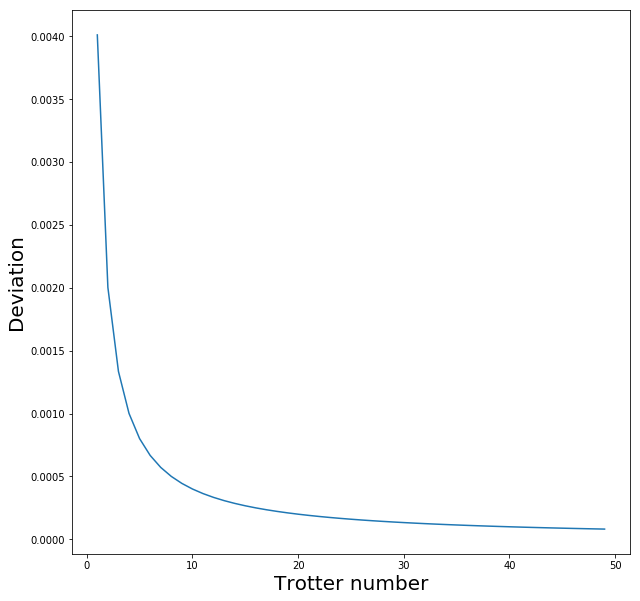

In [64]:
##################################
# Plot this                      #
##################################
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Trotter number",fontsize=20)
ax.set_ylabel("Deviation", fontsize=20)
ax.plot(trotterNumbers, deviations)

Finally, let us verify our Pauli decomposition using OpenFermion.

In [65]:
from openfermion.ops import QubitOperator

In [66]:
########################################################
# Convert a Pauli Decomposition in our format into     #
# a Pauli decomposition in OpenFermion format          #
########################################################
def pauliDecompositionToOpenFermion(D):
    N = np.shape(D)[0]
    K = int(np.log2(N))
    result = QubitOperator('',0)
    for alpha in range(N):
        for beta in range(N):
            coeff = D[alpha][beta]
            if coeff != 0:
                str = ""
                for i in range(K):
                    if (1 == ((alpha > i) % 2)):
                        str = str + "X{} ".format(i)
                    if (1 == ((beta > i) % 2)):
                        str = str + "Z{} ".format(i)    
                result= result + coeff * QubitOperator(str)
            
    return result

In [67]:
check pauliDecompositionToOpenFermion(D2) 
print(check)

SyntaxError: invalid syntax (<ipython-input-67-c3b10977519a>, line 1)

In [ ]:
assert(np.linalg.norm(get_sparse_operator(check).toarray() - H2) < 10**(-12))